# Анализ оттока пользователей телеком оператора

Оператор связи столкнулся с оттоком абонентов, для исправления ситуации маркетинговый отдел планирует предложить планирующим уйти абонентам промокоды и специальные условия. Для успешного запуска маркетингвой кампании необходимо разработать модель прогназирующую уход абонента:

* срок предоставление модели до 14.04.2023 включительно
* метрика модели roc-auc
* критерий качества модели roc-auc>=0.85

Для построения модели предоставлена выгрузка с данными:
* `contract.csv` — информация о договоре;
* `personal.csv` — персональные данные клиента;
* `internet.csv` — информация об интернет-услугах;
* `phone.csv` — информация об услугах телефонии.


In [1]:
## установка недостающих библиотек
!pip install matplotlib==3.7.1
!pip install pandas==1.5.3
!pip install seaborn==0.9.0
!pip install phik==0.12.3
!pip install scikit-learn==1.2.2
!pip install xgboost==1.7.3
!pip install lightgbm==3.3.5
!pip install catboost==1.0.6

     |████████████████████████████████| 11.6 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 70.0 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 97.5 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
     |████████████████████████████████| 12.2 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
     |████████████████████████████████| 208 kB 1.7 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 2

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML
from phik.report import plot_correlation_matrix

import sklearn
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings('ignore', message='.*Found unknown categories in columns*.',
                        category=UserWarning, append=False)

pd.options.mode.chained_assignment = None


## Загрузка и первичный анализ данных

In [3]:
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

except:
    df_contract = pd.read_csv('./datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('./datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('./datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('./datasets/final_provider/phone.csv')


In [4]:
## первичный анализ данных
df_db = {'contract': df_contract,
         'personal': df_personal,
         'internet': df_internet,
         'phone': df_phone}
for key, df in df_db.items():
    display(HTML(f'<h3>{key}</h3>'))
    df.info()
    display(df.describe(include='all'))
    display(df.head(10))
    print()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Данные загружены и первичное знакомство проведено:
* информация для построения целевого признака находится в информации о контрактах в атрибуте EndDate
* Dataframe можно связать по таблице атрибуту customerID, он является уникальным для всех файлов
* файлы содержат данные не по всем клиентам (иначе количество записей было бы одинаковым), поэтому в итоговой информации для обучения будут пропуски, которые мы обработаем в последующих блоках

**Предварительный план на исследование**:
* провести исследовательский анализ данных
  * преобразование типов атрибутов
  * анализ числовых признаков: распределения, пропуски; обработка аномалий
  * анализ категориальных признаков: распределения, пропуски; обработка аномалий
* провести обучение модели с подбором гипер-параметров
* провести тестирование модели для лучшей модели
* написать итоговый вывод

## Исследовательский анализ данных

### Смена типа данных и наименование колонок

#### contract - информация о договоре

In [6]:
## приводим именование колонок к snake-case
df_contract.rename(inplace=True,
                   columns={
                       'customerID': 'customer_id',
                       'BeginDate': 'begin_date',
                       'EndDate': 'end_date',
                       'Type': 'periodic_type',
                       ## добавляем информации к "type" + будет подальше от спец-слова в языке и какой-нибудь библиотеке
                       'PaperlessBilling': 'is_paperless_billing',  ## бинарный признак
                       'PaymentMethod': 'payment_method',
                       'MonthlyCharges': 'monthly_charges',
                       'TotalCharges': 'total_charges'
                   });

df_contract.set_index('customer_id', inplace=True, verify_integrity=True)

In [7]:
## преобразуем типы данных к datetime
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])

In [8]:
df_contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [9]:
## очистим значение для незакрытых контрактов перед преобразованием типа к datetime
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = None
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

In [10]:
## исследуем распределение пропусков в total_charges
df_contract['total_charges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

In [11]:
## проанализируем записи с пустым total_charges
display(df_contract.query('total_charges == " "'))
display(df_contract.query('begin_date >= "2020-02-01"'))

,begin_date,end_date,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,


,begin_date,end_date,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,


In [12]:
## заменим total_charges, тк это записи о новых абонентах (дата начала контракта - соответствует дате выгрузки), значит их общие начисления = 0
df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = 0
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'])

In [13]:
## промежуточный контроль
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   begin_date            7043 non-null   datetime64[ns]
 1   end_date              1869 non-null   datetime64[ns]
 2   periodic_type         7043 non-null   object        
 3   is_paperless_billing  7043 non-null   object        
 4   payment_method        7043 non-null   object        
 5   monthly_charges       7043 non-null   float64       
 6   total_charges         7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


,begin_date,end_date,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


#### personal — персональные данные клиента

In [14]:
## приводим именование колонок к snake-case
df_personal.rename(inplace=True,
                   columns={
                       'customerID': 'customer_id',
                       'SeniorCitizen': 'is_senior_citizen',  ## бинарный признак
                       'Partner': 'has_partner',  ## бинарный признак
                       'Dependents': 'has_dependents'  ## бинарный признак
                   })
df_personal.set_index('customer_id', inplace=True, verify_integrity=True)

In [15]:
## промежуточный контроль
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             7043 non-null   object
 1   is_senior_citizen  7043 non-null   int64 
 2   has_partner        7043 non-null   object
 3   has_dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,is_senior_citizen,has_partner,has_dependents
customer_id,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


#### internet — информация об интернет-услугах

In [16]:
## приводим именование колонок к snake-case
df_internet.rename(inplace=True,
                   columns={
                       'customerID': 'customer_id',
                       'InternetService': 'internet_service',
                       'OnlineBackup': 'has_online_backup',
                       'OnlineSecurity': 'has_online_security',
                       'DeviceProtection': 'has_device_protection',
                       'TechSupport': 'has_tech_support',
                       'StreamingTV': 'has_streaming_tv',
                       'StreamingMovies': 'has_streaming_movies',
                   })
df_internet.set_index('customer_id', inplace=True, verify_integrity=True)

In [17]:
## промежуточный контроль
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   internet_service       5517 non-null   object
 1   has_online_security    5517 non-null   object
 2   has_online_backup      5517 non-null   object
 3   has_device_protection  5517 non-null   object
 4   has_tech_support       5517 non-null   object
 5   has_streaming_tv       5517 non-null   object
 6   has_streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


#### phone — информация об услугах телефонии

In [18]:
## приводим именование колонок к snake-case
df_phone.rename(inplace=True,
                columns={
                    'customerID': 'customer_id',
                    'MultipleLines': 'has_multiple_lines'
                });
df_phone.set_index('customer_id', inplace=True, verify_integrity=True);

In [19]:
## промежуточный контроль
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   has_multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,has_multiple_lines
customer_id,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


### Анализ данных

In [20]:
## классификация признаков для автоматизации дальнейшей обработки
df_db = {'contract': {'data': df_contract,
                      'categorical_columns': ['periodic_type', 'is_paperless_billing', 'payment_method'],
                      'numeric_columns': ['monthly_charges', 'total_charges']
                      },
         'personal': {'data': df_personal,
                      'categorical_columns': ['gender', 'is_senior_citizen', 'has_partner', 'has_dependents'],
                      'numeric_columns': []
                      },
         'internet': {'data': df_internet,
                      'categorical_columns': ['internet_service', 'has_online_security', 'has_online_backup',
                                              'has_device_protection'
                          , 'has_tech_support', 'has_streaming_tv', 'has_streaming_movies'],
                      'numeric_columns': []
                      },
         'phone': {'data': df_phone,
                   'categorical_columns': ['has_multiple_lines'],
                   'numeric_columns': []
                   }
         }

#### Категориальные признаки

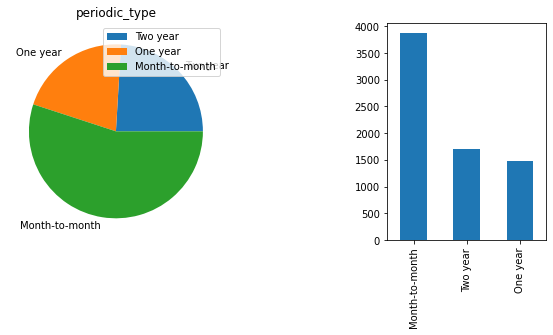

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: periodic_type, dtype: float64

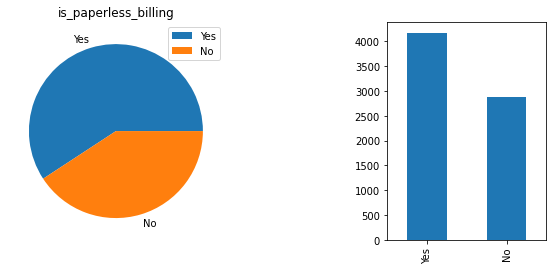

Yes    0.592219
No     0.407781
Name: is_paperless_billing, dtype: float64

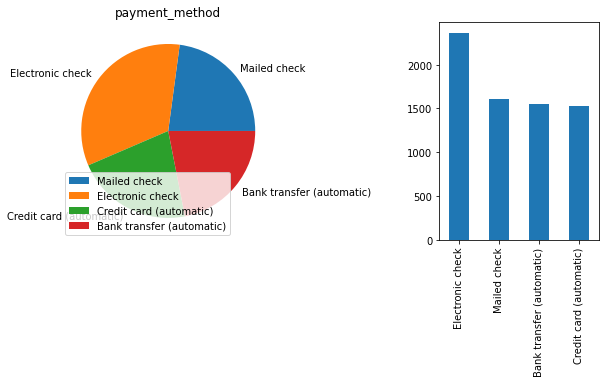

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64

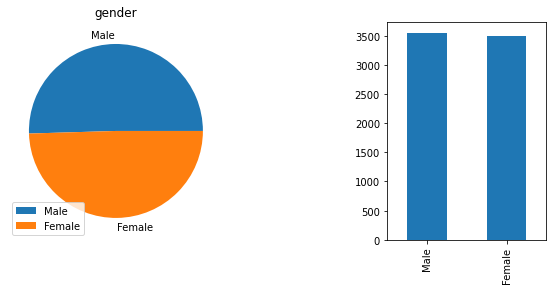

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

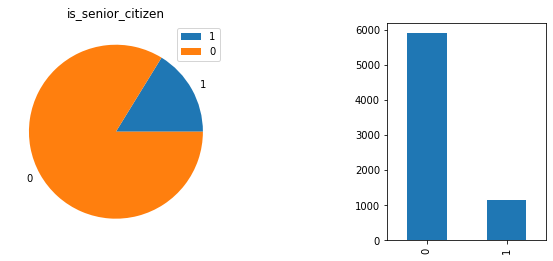

0    0.837853
1    0.162147
Name: is_senior_citizen, dtype: float64

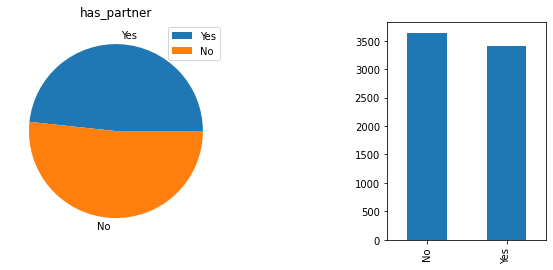

No     0.516967
Yes    0.483033
Name: has_partner, dtype: float64

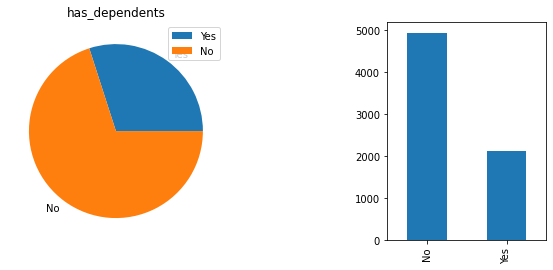

No     0.700412
Yes    0.299588
Name: has_dependents, dtype: float64

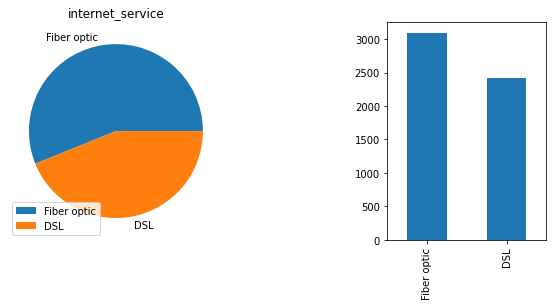

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64

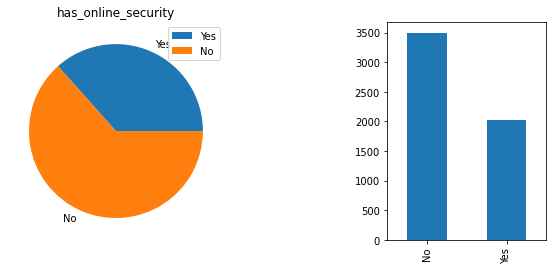

No     0.63404
Yes    0.36596
Name: has_online_security, dtype: float64

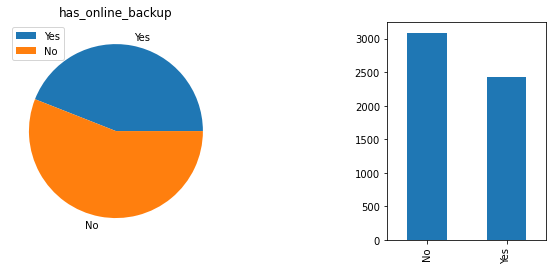

No     0.559724
Yes    0.440276
Name: has_online_backup, dtype: float64

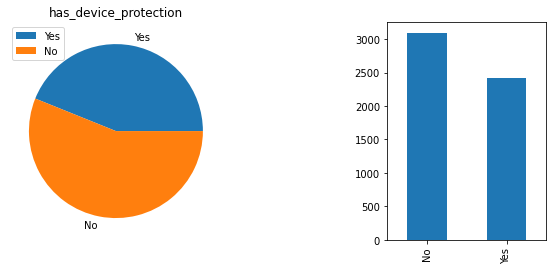

No     0.560993
Yes    0.439007
Name: has_device_protection, dtype: float64

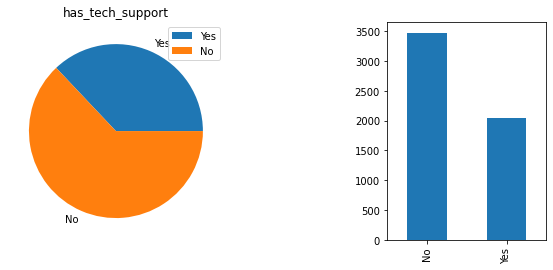

No     0.629509
Yes    0.370491
Name: has_tech_support, dtype: float64

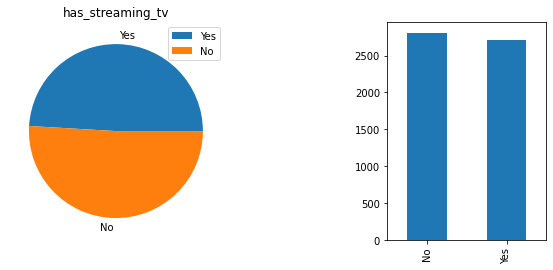

No     0.509335
Yes    0.490665
Name: has_streaming_tv, dtype: float64

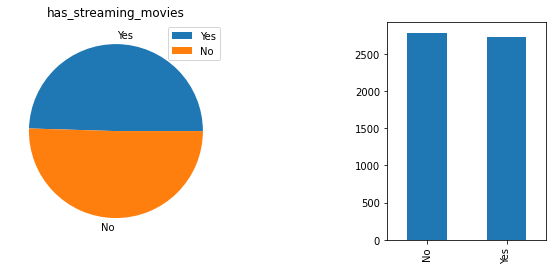

No     0.504803
Yes    0.495197
Name: has_streaming_movies, dtype: float64

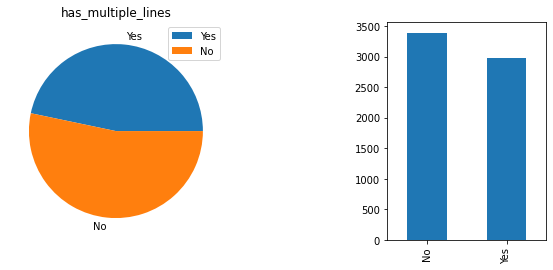

No     0.532935
Yes    0.467065
Name: has_multiple_lines, dtype: float64

In [21]:
## Построим распределения категориальных признаков в различных представлениях: pie, столбчатая диаграмма,
for key, value in df_db.items():
    display(HTML(f'<h2>Dataset \'{key}\'</h2>'))
    data = value['data']
    for column in value['categorical_columns']:
        display(HTML(f'<h3>column \'{column}\'</h3>'))
        fig = plt.figure()
        fig.set_figwidth(12)
        spec = gridspec.GridSpec(ncols=2, nrows=1,
                                 width_ratios=[3, 1], wspace=0.1)
        ax = fig.add_subplot(spec[0])
        data.groupby(column).agg(cnt=(column, 'count')) \
            .sort_values(by=column, ascending=False) \
            .plot(y='cnt', kind='pie', title=column, ax=ax)
        plt.ylabel('')

        ax = fig.add_subplot(spec[1])
        data[column].value_counts().plot(kind='bar', ax=ax)

        plt.show();

        display(data[column].value_counts(normalize=True))

        print()

Распределение категориальных признаков без аномалий

#### Числовые признаки

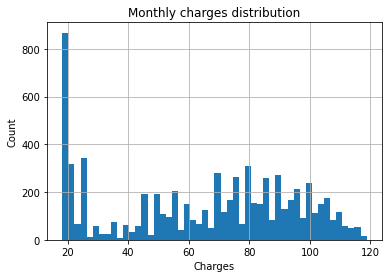

In [22]:
df_contract['monthly_charges'].hist(bins=50);
plt.title('Monthly charges distribution');
plt.ylabel('Count');
plt.xlabel('Charges');

Text(0.5, 0, 'Monthly charges')

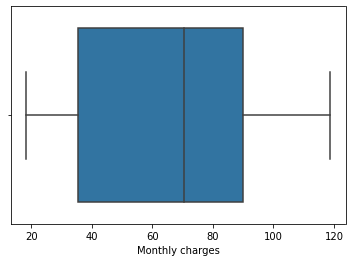

In [23]:
sns.boxplot(x=df_contract['monthly_charges']);
plt.xlabel('Monthly charges')

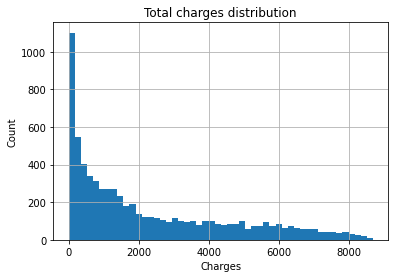

In [24]:
df_contract['total_charges'].hist(bins=50);
plt.title('Total charges distribution');
plt.ylabel('Count');
plt.xlabel('Charges');

Text(0.5, 0, 'Total charges')

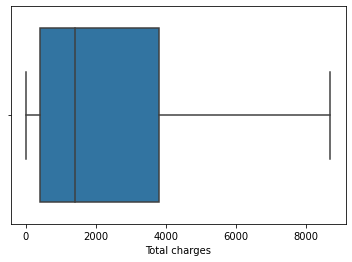

In [25]:
sns.boxplot(x=df_contract['total_charges']);
plt.xlabel('Total charges')

Распределение числовых признаков без аномалий

### Скейка данных

Для дальнейшего исследования соберем данные об обонентах и их контрактов в один dataframe.

In [26]:
df = pd.concat([df_contract, df_personal, df_phone, df_internet], axis=1);
df.info();
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   begin_date             7043 non-null   datetime64[ns]
 1   end_date               1869 non-null   datetime64[ns]
 2   periodic_type          7043 non-null   object        
 3   is_paperless_billing   7043 non-null   object        
 4   payment_method         7043 non-null   object        
 5   monthly_charges        7043 non-null   float64       
 6   total_charges          7043 non-null   float64       
 7   gender                 7043 non-null   object        
 8   is_senior_citizen      7043 non-null   int64         
 9   has_partner            7043 non-null   object        
 10  has_dependents         7043 non-null   object        
 11  has_multiple_lines     6361 non-null   object        
 12  internet_service       5517 non-null   object       

,begin_date,end_date,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [27]:
## добавим явно целевой признак для предсказания
df['is_closed'] = 1
df.loc[df['end_date'].isna(), 'is_closed'] = 0

In [28]:
## посчитаем срок жизни контакта, тк выгрузка была 2020-02-01, то срок - это либо разница end_date и begin_date, либо между begin_date и датой выгрузки (для незакрытых контактов)
df['last_active_date'] = df['end_date']
df.loc[df['end_date'].isna(), 'last_active_date'] = datetime.strptime('2020-02-01', '%Y-%m-%d')
df['contract_duration'] = (df['last_active_date'] - df['begin_date']) / np.timedelta64(1, 'D')

In [29]:
## удалим ненужные для дальнейшего обучения колонки
df.drop(['begin_date', 'end_date', 'last_active_date'], axis=1, inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   periodic_type          7043 non-null   object 
 1   is_paperless_billing   7043 non-null   object 
 2   payment_method         7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   gender                 7043 non-null   object 
 6   is_senior_citizen      7043 non-null   int64  
 7   has_partner            7043 non-null   object 
 8   has_dependents         7043 non-null   object 
 9   has_multiple_lines     6361 non-null   object 
 10  internet_service       5517 non-null   object 
 11  has_online_security    5517 non-null   object 
 12  has_online_backup      5517 non-null   object 
 13  has_device_protection  5517 non-null   object 
 14  has_tech_support       5517 non-null   object 

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,1,61.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,1,61.0


#### Анализ пропусков

In [30]:
df.query('internet_service.isna()').head()

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,
7469-LKBCI,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,488.0
8191-XWSZG,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1584.0
1680-VDCWW,One year,No,Bank transfer (automatic),19.80,202.25,Male,0,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,365.0
1066-JKSGK,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,30.0
7310-EGVHZ,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31.0


In [31]:
df.query('has_multiple_lines.isna()').head()

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,0,31.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0,1371.0
6713-OKOMC,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No,0,306.0
8779-QRDMV,Month-to-month,Yes,Electronic check,39.65,39.65,Male,1,No,No,NaN,DSL,No,No,Yes,No,No,Yes,1,30.0
8665-UTDHZ,Month-to-month,No,Electronic check,30.20,30.20,Male,0,Yes,Yes,NaN,DSL,No,Yes,No,No,No,No,1,30.0


In [32]:
df.query('has_multiple_lines.isna() and internet_service.isna()').head()

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,


На данном этапе в объедененном источнике данных у нас есть пропуски, которые пропуски продиктованы тем, что пользователь может подключить всего одну из услуг телефонию или интернет, поэтому заполеним такие признаки эквивалентом неиспользования - заполним No, а прочие категориальные и has_multiple_lines - 'NotUsed'

In [33]:
## заполним пропуски
values = {'has_multiple_lines':'NotUsed',
          'has_online_security':'No',
          'has_online_backup':'No',
          'has_device_protection':'No',
          'has_tech_support':'No',
          'has_streaming_tv':'No',
          'has_streaming_movies':'No',
          'internet_service':'NotUsed'}

df.fillna(value=values, inplace=True);

df.info();
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   periodic_type          7043 non-null   object 
 1   is_paperless_billing   7043 non-null   object 
 2   payment_method         7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   gender                 7043 non-null   object 
 6   is_senior_citizen      7043 non-null   int64  
 7   has_partner            7043 non-null   object 
 8   has_dependents         7043 non-null   object 
 9   has_multiple_lines     7043 non-null   object 
 10  internet_service       7043 non-null   object 
 11  has_online_security    7043 non-null   object 
 12  has_online_backup      7043 non-null   object 
 13  has_device_protection  7043 non-null   object 
 14  has_tech_support       7043 non-null   object 

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NotUsed,DSL,No,Yes,No,No,No,No,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,1,61.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NotUsed,DSL,Yes,No,Yes,Yes,No,No,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,1,61.0


#### Корреляционный анализ

In [34]:
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']
phik_overview = df.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
periodic_type,1.00,0.11,0.28,0.39,0.51,0.00,0.09,0.18,0.15,0.24,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.25,0.66
is_paperless_billing,0.11,1.00,0.37,0.47,0.21,0.00,0.24,0.01,0.17,0.10,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.30,0.00
payment_method,0.28,0.37,1.00,0.40,0.35,0.00,0.29,0.24,0.22,0.17,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.45,0.38
monthly_charges,0.39,0.47,0.40,1.00,0.76,0.01,0.30,0.20,0.18,0.71,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.36,0.41
total_charges,0.51,0.21,0.35,0.76,1.00,0.00,0.15,0.42,0.12,0.49,0.51,0.55,0.65,0.67,0.57,0.66,0.67,0.28,0.84
gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
is_senior_citizen,0.09,0.24,0.29,0.30,0.15,0.00,1.00,0.02,0.32,0.09,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.23,0.03
has_partner,0.18,0.01,0.24,0.20,0.42,0.00,0.02,1.00,0.65,0.09,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.23,0.49
has_dependents,0.15,0.17,0.22,0.18,0.12,0.00,0.32,0.65,1.00,0.01,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.25,0.21
has_multiple_lines,0.24,0.10,0.17,0.71,0.49,0.00,0.09,0.09,0.01,1.00,0.74,0.10,0.14,0.15,0.10,0.17,0.17,0.02,0.37


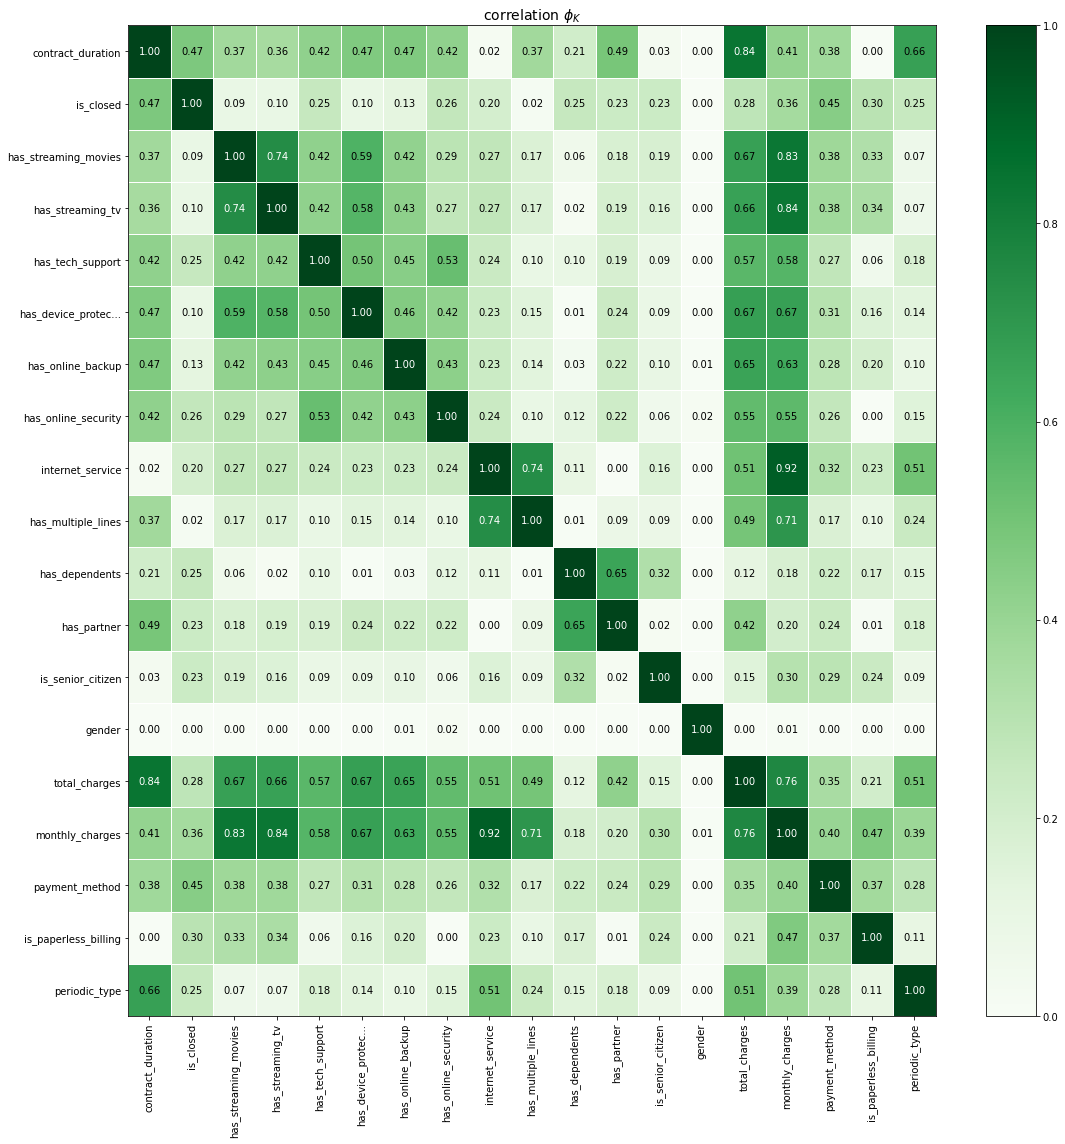

In [54]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.0,
                        figsize=(16, 16))
plt.tight_layout()

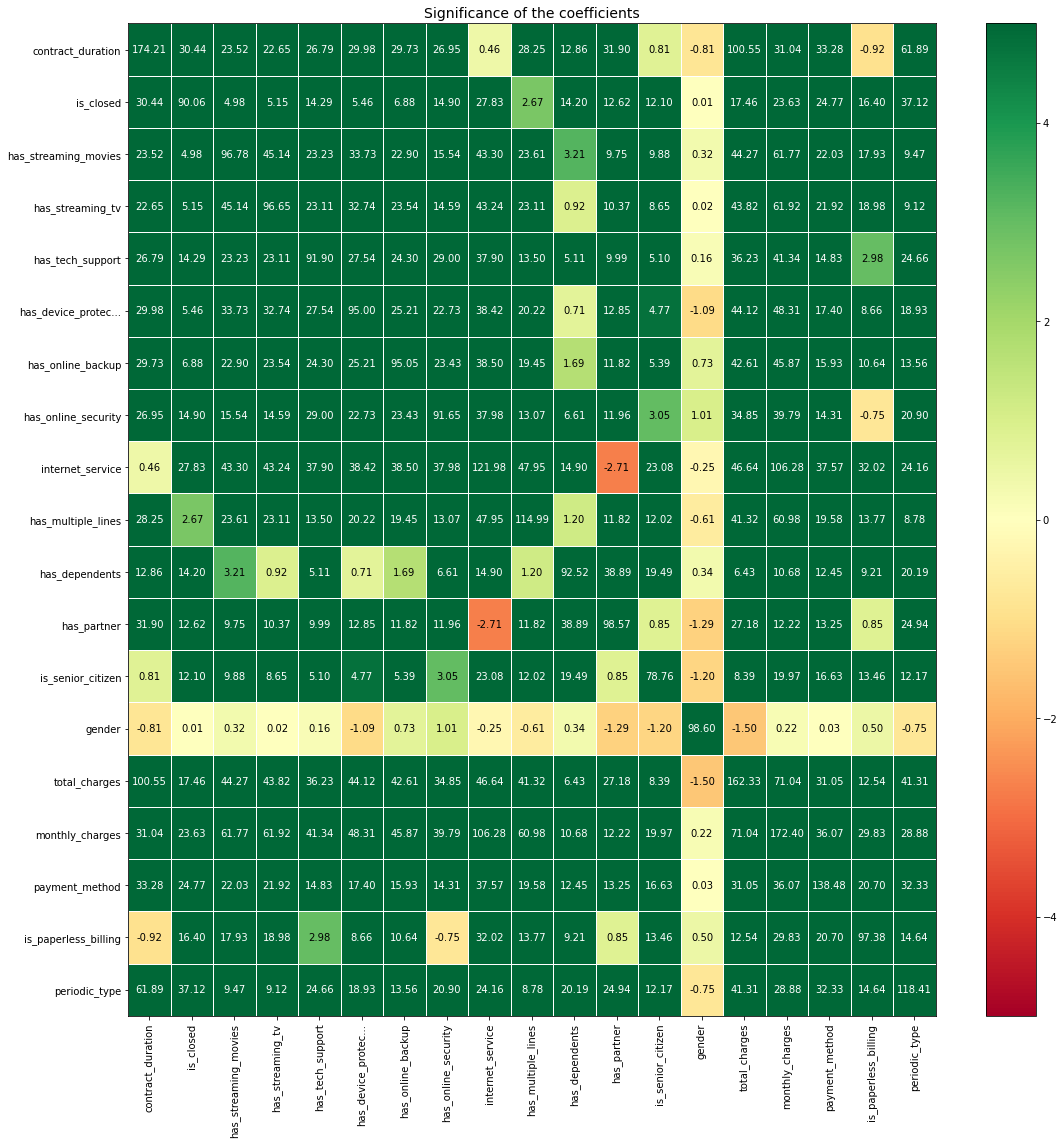

In [36]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.0, figsize=(16, 16))
plt.tight_layout()

/opt/conda/lib/python3.9/site-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


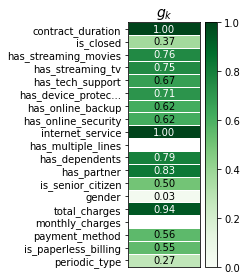

In [37]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation,
                        x_labels=[''], y_labels=global_labels,
                        vmin=0, vmax=1, figsize=(3.5, 4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.0)
plt.tight_layout()


Анализ на мультиколлинеартность не показывает сильной корреляции между признаками и целевым признаком - утечка данных целевого признака не обнаружена

In [38]:
df.info();
display(df.describe(include='all'))
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   periodic_type          7043 non-null   object 
 1   is_paperless_billing   7043 non-null   object 
 2   payment_method         7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   gender                 7043 non-null   object 
 6   is_senior_citizen      7043 non-null   int64  
 7   has_partner            7043 non-null   object 
 8   has_dependents         7043 non-null   object 
 9   has_multiple_lines     7043 non-null   object 
 10  internet_service       7043 non-null   object 
 11  has_online_security    7043 non-null   object 
 12  has_online_backup      7043 non-null   object 
 13  has_device_protection  7043 non-null   object 
 14  has_tech_support       7043 non-null   object 

,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
count,7043,7043,7043,7043.000000,7043.000000,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,3,2,2,2,2,2,2,NaN,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,No,Fiber optic,No,No,No,No,No,No,NaN,NaN
freq,3875,4171,2365,NaN,NaN,3555,NaN,3641,4933,3390,3096,5024,4614,4621,4999,4336,4311,NaN,NaN
mean,NaN,NaN,NaN,64.761692,2279.734304,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265370,985.996166
std,NaN,NaN,NaN,30.090047,2266.794470,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441561,747.587844
min,NaN,NaN,NaN,18.250000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,35.500000,398.550000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,273.000000
50%,NaN,NaN,NaN,70.350000,1394.550000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,883.000000
75%,NaN,NaN,NaN,89.850000,3786.600000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1676.000000


,periodic_type,is_paperless_billing,payment_method,monthly_charges,total_charges,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_closed,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NotUsed,DSL,No,Yes,No,No,No,No,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,1,61.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NotUsed,DSL,Yes,No,Yes,Yes,No,No,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,1,61.0


### Промежуточный вывод

В рамках данного раздела мы провели:
* анализ аномалий в распределении данных - аномалий не обнаружено
* склейку данных в итоговый dataframe
* расширили список признаков длительностью контракта (на момент закрытия или на момент выгрузки)
* провели корреляционный анализ признаков, утечка целевого признака не обнаружена

## Обучение модели

In [39]:
## константы для обучения
RANDOM_STATE = 70423
TEST_SIZE = 0.25
CV_BLOCK_COUNT = 5

Поставленная задача - является классической задачей бинайрной классификации

In [40]:
## признаки и их классификация
NUMERIC_FEATURE_NAMES = ['contract_duration', 'monthly_charges', 'total_charges']
CATEGORICAL_FEATURE_NAMES = ['periodic_type', 'is_paperless_billing', 'payment_method', 'is_senior_citizen',
                             'has_partner', 'has_dependents', 'has_multiple_lines', 'internet_service',
                             'has_online_security', 'has_online_backup', 'has_device_protection', 'has_tech_support',
                             'has_streaming_tv', 'has_streaming_movies', 'gender']
TARGET_NAME = 'is_closed'


In [41]:
## анализ дисбаланса классов
df[TARGET_NAME].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: is_closed, dtype: float64

распределение предсказуемых классов ~ 1:3, поэтому при разделении будем использовать стратификацию, дополнительных методик борьбы с дисбалансом - использовать не будем, на целевую метрику ROC-AUC - это не влияет

In [42]:
## подготовим данные для обучения и тестирования модели
features_train, features_test, target_train, target_test = train_test_split(
    df[NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES],
    df[TARGET_NAME],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[TARGET_NAME]
)

In [43]:
## метрика качества
target_scorer = 'roc_auc'

In [44]:
## конструктор для pipeline и вспомогательные функции
class CategoryTypeTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.columns:
            X[feature] = pd.Series(X[feature], dtype="category")
        return X

def create_model(model_class):
    if model_class in [ LogisticRegression,
                        DecisionTreeClassifier,
                        RandomForestClassifier,
                        GradientBoostingClassifier,
                        XGBClassifier,
                        LGBMClassifier]:
        model = model_class(random_state=RANDOM_STATE)
    elif model_class in [CatBoostClassifier]:
        model = model_class(random_state=RANDOM_STATE,
                            silent=True)
    else:
        model = model_class()

    return model

def create_ordinal_encoder():
    return Pipeline(steps=[('order-end',
                            OrdinalEncoder(handle_unknown='use_encoded_value',
                                           unknown_value=-666
                                           )
                            )]
                    )

def create_column_transformer(model_class):

    col_trans = ColumnTransformer(transformers=[])

    col_trans.transformers.append(('num_pipeline',
                                   Pipeline(steps=[
                                       ('scale', StandardScaler())
                                   ]),
                                   NUMERIC_FEATURE_NAMES
                                   ))

    cat_pipeline = None
    if model_class in [LogisticRegression]:
        cat_pipeline = Pipeline(steps=[
            ('one-hot', OneHotEncoder(sparse_output=False,
                                      drop='first',
                                      handle_unknown='ignore'))
        ])
    elif model_class in [DecisionTreeClassifier, RandomForestClassifier,
                         GradientBoostingClassifier, XGBClassifier, CatBoostClassifier]:
        cat_pipeline = create_ordinal_encoder()

    elif model_class in [LGBMClassifier]:
        cat_pipeline = Pipeline(steps=[('category-type',
                                        CategoryTypeTransformer(columns=CATEGORICAL_FEATURE_NAMES
                                                                )
                                        )]
                                )
        col_trans.set_output(transform='pandas')

    else:
        print('passthrough')
        col_trans.remainder = 'passthrough'



    if cat_pipeline != None:
        col_trans.transformers.append(('cat_pipeline',
                                       cat_pipeline,
                                       CATEGORICAL_FEATURE_NAMES
                                       ))


    return col_trans


def create_pipeline(model_class):
    model = create_model(model_class)
    col_trans =  create_column_transformer(model_class)
    return Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', model)
    ])


def train_and_test(pipeline, features, target):
    result_score = cross_val_score(pipeline,
                           features, target,
                           scoring=target_scorer,
                           cv=CV_BLOCK_COUNT, n_jobs=-1).mean()
    return result_score



def print_transform_shape(model_class):
    print(f'{model_class.__name__} до трансформации {features_train.shape}')
    pipeline = create_pipeline(model_class)
    features_trans = pipeline[0].fit_transform(features_train)

    print(f'{model_class.__name__} после трансформации {features_trans.shape}')
#     display(features_trans)


### Обучение выбранных моделей с параметрами по-умолчанию

In [45]:
## список классов моделей, которые будем исследовать
models = [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    XGBClassifier,
    CatBoostClassifier,
    LGBMClassifier
]

In [47]:
for model_class in models:
    print(f'Classifier {model_class.__name__}')
    pipeline = create_pipeline(model_class)
    %time score = train_and_test(pipeline, features_train, target_train)
    print(f'roc-auc-cv = {score:0.4f}')
    print()


Classifier DummyClassifier
passthrough
CPU times: user 88.6 ms, sys: 7 µs, total: 88.6 ms
Wall time: 95 ms
roc-auc-cv = 0.5000

Classifier LogisticRegression
CPU times: user 1.64 s, sys: 1.97 s, total: 3.61 s
Wall time: 3.53 s
roc-auc-cv = 0.8417

Classifier DecisionTreeClassifier
CPU times: user 306 ms, sys: 56.3 ms, total: 363 ms
Wall time: 453 ms
roc-auc-cv = 0.6932

Classifier RandomForestClassifier
CPU times: user 2.8 s, sys: 27.5 ms, total: 2.83 s
Wall time: 2.84 s
roc-auc-cv = 0.8413

Classifier GradientBoostingClassifier
CPU times: user 3.3 s, sys: 0 ns, total: 3.3 s
Wall time: 3.3 s
roc-auc-cv = 0.8843

Classifier XGBClassifier
CPU times: user 2.62 s, sys: 67.2 ms, total: 2.69 s
Wall time: 2.69 s
roc-auc-cv = 0.8912

Classifier CatBoostClassifier
CPU times: user 11.8 s, sys: 456 ms, total: 12.2 s
Wall time: 15.2 s
roc-auc-cv = 0.8930

Classifier LGBMClassifier
CPU times: user 1min 13s, sys: 481 ms, total: 1min 14s
Wall time: 1min 14s
roc-auc-cv = 0.8900



с параметрами по-умолчанию с требуемым уровнем целевой метрики (0.85) справились:
* GradientBoostingClassifier - 0.8843
* XGBClassifier - 0.8912
* CatBoostClassifier - 0.8930
* LGBMClassifier -  0.8900

для дальнейшго подбора гипер-параметров возмеме
* XGBClassifier - лучше всего справилась
* LGBMClassifier - альтернативный вариант с градиентным бустингом (самый быстрый)
* RandomForestClassifier - не справилась, но можно посмотреть чего получится достичь с подбором гипер-параметров + альтернативный вариант без градиентного бустинга
* LogisticRegression - не справилась, но можно посмотреть чего получится достичь с подбором гипер-параметров + альтернативный вариант без деревьев

### Обучение моделей с подбором параметров

In [ ]:
def get_models_and_params_search_space(use_found_params:bool=False):
    """
    Возвращает словарь моделей и пространство поиска гипер-параметров для каждой модели
    use_found_params - использовать ранее найденные параметры или нет
    """

    if use_found_params:
        return {
          XGBClassifier:{
                      'params':[{'model__n_estimators': [290],
                                 'model__max_depth': [2],
                                 'model__learning_rate': [0.5]
                                }]
                     },
          LGBMClassifier:{
                      'params':[{'model__n_estimators': [290],
                                 'model__max_depth': [2],
                                 'model__learning_rate': [0.5]
                                }]
                     },
          RandomForestClassifier: {
                      'params':[{'model__n_estimators': [270],
                                 'model__max_depth': [8],
                                 'model__min_samples_split': [3],
                                 'model__min_samples_leaf': [1]
                                }]
                     },
          LogisticRegression: {
                      'params':[{'model__penalty': ['l1'],
                                 'model__C': [1],
                                 'model__max_iter':[1000],
                                 'model__solver': ['saga']
                                }]
                     },
        }
    else:
        return {
          XGBClassifier:{
                      'params':[{'model__n_estimators': [i for i in range(50, 301, 20)],
                                 'model__max_depth': [i for i in range(2, 30, 3)],
                                 'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
                                }]
                     },
          LGBMClassifier:{
                      'params':[{'model__n_estimators': [i for i in range(50, 301, 20)],
                                 'model__max_depth': [-1]+[i for i in range(2, 30, 3)],
                                 'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
                                }]
                     },
          RandomForestClassifier: {
                      'params':[{'model__n_estimators': [i for i in range(50, 301, 20)],
                                 'model__max_depth': [i for i in range(2, 30, 3)],
                                 'model__min_samples_split': [2, 3, 4, 5],
                                 'model__min_samples_leaf': [1, 2, 3, 4, 5]
                                }]
                     },
          LogisticRegression: {
                      'params':[{'model__penalty': ['l1','l2'],
                                 'model__C': np.logspace(-3,3,7),
                                 'model__max_iter':[1000],
                                 'model__solver':['liblinear', 'saga']
                                }]
                     },
        }



In [49]:
best_models =[]
searches = get_models_and_params_search_space(use_found_params=True)
for key, value in searches.items():
    display(HTML(f'<h3>{key.__name__}</h3>'))
    pipeline = create_pipeline(key)
    

    grid_search = GridSearchCV(pipeline, 
                                 value['params'],
                                 cv=CV_BLOCK_COUNT,
                                 scoring=target_scorer,
                                 n_jobs=-1
                            )

    grid_search.fit(features_train, target_train)
    print(f'best score {grid_search.best_score_:0.4f}')
    print(f'best estimator params {grid_search.best_params_}')
    best_models.append([key, grid_search, grid_search.best_score_, grid_search.best_estimator_])
    print()


best score 0.9068
best estimator params {'model__learning_rate': 0.5, 'model__max_depth': 2, 'model__n_estimators': 290}



best score 0.9139
best estimator params {'model__learning_rate': 0.5, 'model__max_depth': 2, 'model__n_estimators': 290}



best score 0.8572
best estimator params {'model__max_depth': 8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 270}



best score 0.8419
best estimator params {'model__C': 1, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'saga'}



### Тестирование модели

best model roc_auc-cv for train = 0.9139
roc_auc for test = 0.9284
accuracy for test = 0.8779


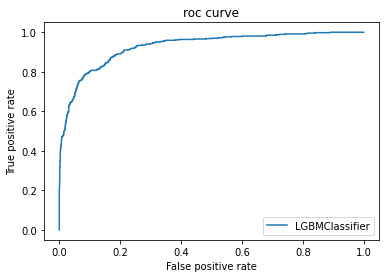

In [50]:
model_base_class = None
best_trained_model = None
best_score = 0
for dd in best_models:
    if dd[1].best_score_ > best_score:
        best_trained_model = dd[1]
        best_score=dd[1].best_score_

        
print(f'best model roc_auc-cv for train = {best_trained_model.best_score_:0.4f}')     
probabilities_test = best_trained_model.predict_proba(features_test)[:, 1]
roc_auc_test = roc_auc_score(target_test, probabilities_test)
print(f'roc_auc for test = {roc_auc_test:0.4f}')
print(f'accuracy for test = {accuracy_score(target_test, best_trained_model.predict(features_test)):0.4f}')




fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)
plt.plot(fpr, tpr, label=type(best_trained_model.best_estimator_[1]).__name__);

plt.title('roc curve');
plt.legend()
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');


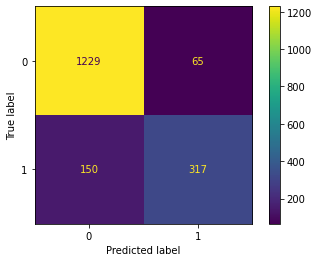

In [51]:
cm = confusion_matrix(target_test, best_trained_model.predict(features_test));

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=best_trained_model.best_estimator_[1].classes_).plot();

Обученная модель на тестовой выборке показала следующие результаты:
* ROC-AUC - 0.9284
* точность предсказания класса - 88%
* неверное предсказание ухода абонента (False omission rate) - 17%
* пропуск ухода абонента (False positive rate) - 32%

In [52]:
## проверка важности признаков
params_importance = np.vstack((['contract_duration',
                                'monthly_charges',
                                'total_charges',
                                'periodic_type',
                                'is_paperless_billing',
                                'payment_method',
                                'is_senior_citizen',
                                'has_partner',
                                'has_dependents',
                                'has_multiple_lines',
                                'internet_service',
                                'has_online_security',
                                'has_online_backup',
                                'has_device_protection',
                                'has_tech_support',
                                'has_streaming_tv',
                                'has_streaming_movies',
                                'gender'],
                              best_trained_model.best_estimator_[1].feature_importances_
                             )).T
df_importance = pd.DataFrame(params_importance, columns=['feature', 'importance']);
df_importance['importance'] = pd.to_numeric(df_importance['importance'])
display(df_importance.sort_values(by='importance', ascending=False))


,feature,importance
0,contract_duration,424
2,total_charges,199
1,monthly_charges,140
3,periodic_type,17
17,gender,13
5,payment_method,11
4,is_paperless_billing,11
9,has_multiple_lines,8
14,has_tech_support,7
6,is_senior_citizen,6


### Промежуточный вывод

Лучшая модель найдена:
* базовый класс модели - LGBMClassifier
* гипер-параметры - 'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 290
* ROC-AUC - 0.9284
* точность предсказания класса - 88%
* неверное предсказание ухода абонента (False omission rate) - 17%
* пропуск ухода абонента (False positive rate) - 32%

необходимый порог качества модели 0.85 для roc_auc преодален

обученная модель показывает следющие показатели значимости для модели
* contract_duration	424
* total_charges	199
* monthly_charges	140
* periodic_type	17
* gender	13
* payment_method	11
* is_paperless_billing	11
* has_multiple_lines	8
* has_tech_support	7
* is_senior_citizen	6
* internet_service	6
* has_online_security	6
* has_dependents	4
* has_streaming_tv	4
* has_partner	3
* has_online_backup	3
* has_device_protection	3
* has_streaming_movies	3

## Итоговый Отчет


### Постановка задачи
Оператор связи столкнулся с оттоком абонентов, для исправления ситуации маркетинговый отдел планирует предложить планирующим уйти абонентам промокоды и специальные условия. Для успешного запуска маркетингвой кампании необходимо разработать модель прогназирующую уход абонента:

* срок предоставление модели до 14.04.2023 включительно
* метрика модели roc-auc
* критерий качества модели roc-auc>=0.85



### Описание исходных данных

Для построения модели предоставлена выгрузка с данными (дата выгрузки 2020.02.01):
* `contract.csv` — информация о договоре
  * customerID - Идентификатор клиента
  * BeginDate - Дата начала контракта
  * EndDate - Дата завершения контракта
  * Type - Типа периодичности оплаты (помесячно, раз в год и тп)
  * PaperlessBilling - Безналичный расчет
  * PaymentMethod - Тип оплаты
  * MonthlyCharges - Ежемесячные траты на услуги
  * TotalCharges - Суммарные траты на услуги за период действия договора

  7043 - уникальных записей


* `personal.csv` — персональные данные клиента
  * customerID - Идентификатор клиента
  * gender - Пол клиента
  * SeniorCitizen - Наличие пенсионного статуса по возрасту
  * Partner - Наличие супруга(и)
  * Dependents - наличие иждивенцев

  7043 - уникальных записей



* `internet.csv` — информация об интернет-услугах
  * customerID - Идентификатор клиента
  * InternetService - Тип подключения (Fiber optic, DSL и тп)
  * OnlineSecurity - Наличие услуги "Блокировка небезопасных сайтов"
  * OnlineBackup - Наличие услуги "Облачное хранилище файлов для резервного копирования данных"
  * DeviceProtection - Наличие услуги "Антивирус"
  * TechSupport - Наличие услуги "Выделенная линия технической поддержки"
  * StreamingTV - Наличие услуги "Стриминговое телевидение"
  * StreamingMovies - Наличие услуги "Каталог фильмов"

  5517 - уникальных записей

* `phone.csv` — информация об услугах телефонии
  * customerID - Идентификатор клиента
  * MultipleLines - Подключение телефонного аппарата к нескольким линиям одновременно

  6361 - уникальных записей



### План иследования

Исследования строилось по следующему плану

* провести исследовательский анализ данных
  * преобразование типов атрибутов
  * анализ числовых признаков: распределения, пропуски; обработка аномалий
  * анализ категориальных признаков: распределения, пропуски; обработка аномалий
* провести обучение модели с подбором гипер-параметров
* провести тестирование модели для лучшей модели
* написать итоговый вывод

Все шаги были выполнены.


### Предобработка данных и дополнительные признаки

В рамках анализа балы выявленая только одна аномалия - 11 записей с датой начала контракта 2020.02.01 (дата выгрузки) имели пропуски в TotalCharges, данные пропуски были заполнены 0.
Несовпадение количества записей в contract и в internet\phone - объясняется отсуnствие той или иной услуги у клиента.

В рамках предобработки данных было проведено:
* переименование признаков к формату snake_case
* cклейка данных в итогоговую таблицу по индентификатору клиента
* заполенение пропущенных данных:
  * для признаков наличия услуг - использовалось значение эквивалетное отсуствию услугиу (значение No)
  * для прочих категориальных признаков (MultipleLines, InternetService) - использовалось отдельное значение NotUsed
* выделение целевого признака на основании "Дата завершения контракта"
* создание дополнительного признака "Длительность контракта":
  * для завершенных контрактов - разница в днях между "Дата начала контракта" и "Дата завершения контракта"
  * для незавершенных контрактов - разница в днях между "Дата начала контракта" и датой выгрузки (2020.02.01)
* переименование признаков к формату snake_case
* удаление признаков неиспользуемых для дальнейшего обучения модели
  * BeginDate - Дата начала контракта
  * EndDate - Дата завершения контракта

Дополнительно был проведен анализ признаков на мультиколлинеарность с использованием бибиотеки python - phik - проверка не выявила утечки целевого признака в признаки для обучения
![correlation_matrix.png](./screenshot/correlation_matrix.png)

### Обучение и выбор лучшей модели
Исходный dataset для обучения модели состоял из 7043 записей с 19 признаками в каждой, включая целевой.
Задача обучения модели решалась, как классическая задача бинарной классификации.
Перед обучением данные были разделены на обучающую и тестовую выборку в соотношении 3:1, тк данные не показывали существенного дисбаланса целевого признака (отношение класос ~1:3), то на этапе разделения использовалась стратификация по целевому признаку.

Для поиска лучшей модели рассматривались следующие модели:
* XGBClassifier
* LGBMClassifier
* RandomForestClassifier (случайный лес)
* LogisticRegression (логистическая регрессия)

каждая из моделей обучалась с поиском наилучшего набора грипер-параметров в следующих наборах
* XGBClassifier
  * n_estimators - `[i for i in range(50, 301, 20)]`
  * max_depth - `[i for i in range(2, 30, 3)]`
  * learning_rate - `[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]`
* LGBMClassifier
  * n_estimators - `[i for i in range(50, 301, 20)]`
  * max_depth - `[i for i in range(2, 30, 3)]`
  * learning_rate - `[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]`
* RandomForestClassifier (случайный лес)
  * n_estimators - `[i for i in range(50, 301, 20)]`
  * max_depth - `[i for i in range(2, 30, 3)]`
  * min_samples_split - `[2, 3, 4, 5]`
  * min_samples_leaf - `[1, 2, 3, 4, 5]`
* LogisticRegression (логистическая регрессия)
  * penalty - `['l1','l2']`
  * C - `np.logspace(-3,3,7)`
  * max_iter - `[1000]`
  * solver - `['liblinear', 'saga']`


обучение строилось в виде pipeline c 2vz этапами:
1. Обработка данных, где
* количественные признаки обрабатывались (Ежемесячные траты на услуги, Суммарные траты на услуги за период действия договора, Длительность контракта) `StandardScaler`
* Обработка категориальных признаков зависила от базовой модели:
  * XGBClassifier - `OrdinalEncoder`
  * LGBMClassifier - категориальные данные передавались без изменений
  * RandomForestClassifier (случайный лес) - `OrdinalEncoder`
  * LogisticRegression (логистическая регрессия) - `OneHotEncoder(drop='first', handle_unknown='ignore')`

Лучшая модель определялась на основании кросс-валидации с 5 блоками по метрике ROC-AUC.

Наилучших результатов добилась модель LGBMClassifier с параметрами:
* learning_rate - 0.5
* max_depth - 2
* n_estimators - 290

Метрика на обучающей выбокре - 0.9139

### Тестирование и анализ обученной модели
Тестирование лучше модели происходило на заранее отложенной выборке (25% от исходного объема данных)
По результатам тестирования модель показала следующие параметры качества:
* ROC-AUC - 0.9284 (требуемое значение метрики (>=0.85) достигнуто)

![roc_auc_curve.png](./screenshot/roc_auc_curve.png)

* точность предсказания классов (accuracy) - 88%
* неверное предсказание ухода абонента (False omission rate) - 17%
* пропуск ухода абонента (False positive rate) - 32%

![confision_matrix.png](./screenshot/confision_matrix.png)


Следущие признаки показали наибольшую значимость для обученной модели:
* Длительность контракта  - 424
* Суммарные траты на услуги за период действия договора - 199
* Ежемесячные траты на услуги 140

### Итог

Модель обучена до требуемго уровня
* ROC-AUC - 0.9284 (>=0.85)
* accuracy - 88%

Модель готова для использования в планируемой маркетинговой кампании
